In [7]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [8]:
base_dir = '../data/fruits-360/'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir) 

#Img size

img_height = 299
img_width = 299

In [9]:
# Data preprocessing - ImageDataGenerator

# Normalize the pixels in the train data images, resize and augment the data
train_datagen = ImageDataGenerator(
    rescale=1./255,# Image augmentaion 
    shear_range=0.2,
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, #  Flip the image horizontally
    validation_split=0.2
    ) # Split 20% of the data for validation

# Normalize the test data images
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training') # Set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # Same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # Set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
# Only 13 clases - 10% of the data

# Data preprocessing - ImageDataGenerator

# Normalize the pixels in the train data images, resize and augment the data
train_datagen = ImageDataGenerator(
    rescale=1./255,# Image augmentaion 
    shear_range=0.2,
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, #  Flip the image horizontally
    validation_split=0.2) # Split 20% of the data for validation

# Normalize the test data images
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=True,
    classes=['Apple Red 2', 'Avocado', 'Banana', 'Cherry 2', 'Kiwi', 'Lemon', 'Mandarine', 'Peach', 'Pineapple', 'Raspberry', 'Strawberry', 'Tomato 1', 'Watermelon'],
    class_mode='categorical',
    subset='training') # Set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # Same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    classes=['Apple Red 2', 'Avocado', 'Banana', 'Cherry 2', 'Kiwi', 'Lemon', 'Mandarine', 'Peach', 'Pineapple', 'Raspberry', 'Strawberry', 'Tomato 1', 'Watermelon'],
    class_mode='categorical',
    subset='validation') # Set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    classes=['Apple Red 2', 'Avocado', 'Banana', 'Cherry 2', 'Kiwi', 'Lemon', 'Mandarine', 'Peach', 'Pineapple', 'Raspberry', 'Strawberry', 'Tomato 1', 'Watermelon'],
    class_mode='categorical')

In [10]:
# Create the model based on the InceptionV3 architecture

# InceptionV3 model and use the weights from imagenet
conv_base = keras.applications.InceptionV3(
            include_top=False,
            weights="imagenet",
            input_shape=(img_height, img_width, 3)
)

conv_base.trainable = False # Freeze the base model layers

InceptionV3_model = conv_base.output
pool = GlobalAveragePooling2D()(InceptionV3_model)
dense_1 = layers.Dense(512, activation = 'relu')(pool)
output = layers.Dense(131, activation = 'softmax')(dense_1)

# Create an example of the Archictecture to plot on a graph
model_inception = models.Model(inputs=conv_base.input, outputs=output)

model_inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [11]:
# Compile the model
model_inception.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
with tf.device("/device:GPU:0"):
    history = model_inception.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        verbose = 1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
    
# Save the model
def save_model(model, seed):
    model.save(f"../models/inceptionv3-{seed}")
    
save_model(model_inception, 4)

Epoch 1/10


2022-12-12 17:06:40.352818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1694/1694 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.9123

2022-12-12 17:15:03.566597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1694/1694 [==============================] - 631s 371ms/step - loss: 0.3710 - accuracy: 0.9123 - val_loss: 0.1944 - val_accuracy: 0.9393
Epoch 2/10
1694/1694 [==============================] - 616s 363ms/step - loss: 0.0562 - accuracy: 0.9839 - val_loss: 0.2218 - val_accuracy: 0.9374
Epoch 3/10
1694/1694 [==============================] - 620s 366ms/step - loss: 0.0487 - accuracy: 0.9851 - val_loss: 0.1265 - val_accuracy: 0.9640
Epoch 4/10
1694/1694 [==============================] - 614s 362ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.1519 - val_accuracy: 0.9576
Epoch 5/10
1694/1694 [==============================] - 615s 363ms/step - loss: 0.0403 - accuracy: 0.9884 - val_loss: 0.1413 - val_accuracy: 0.9603
Epoch 6/10
1694/1694 [==============================] - 604s 356ms/step - loss: 0.0351 - accuracy: 0.9896 - val_loss: 0.2605 - val_accuracy: 0.9330


INFO:tensorflow:Assets written to: ../models/inceptionv3-4/assets


INFO:tensorflow:Assets written to: ../models/inceptionv3-4/assets


In [13]:
# Test the model

loss, accuracy = model_inception.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.3f}, Test loss: {loss:.3f}')

709/709 [==============================] - 117s 164ms/step - loss: 0.1805 - accuracy: 0.9509
Test accuracy: 0.951, Test loss: 0.181


In [17]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image

model_inception = keras.models.load_model('../models/inceptionv3-4')
class_dict = test_generator.class_indices # a dictionary of the form class name: class index

def classify(img_path):    
    img = image.load_img(img_path, target_size=(299, 299))
        
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)
    
    prediction = model_inception.predict(img_preprocessed)

    return prediction

pred = classify('../test.png')

score = tf.nn.softmax(pred[0])

klass = [k for k, v in class_dict.items() if v == np.argmax(score)][0]

print(f'Predicted class: {klass}, Probability: {np.argmax(score):.3f}')

2022-12-12 18:21:10.733090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
Predicted class: Banana Lady Finger, Probability: 17.000


<Figure size 1000x500 with 0 Axes>

<AxesSubplot: >

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

Text(0.5, 1.0, 'Training and Validation Accuracy')

<Figure size 1000x500 with 0 Axes>

<AxesSubplot: >

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

Text(0.5, 1.0, 'Training and Validation Loss')

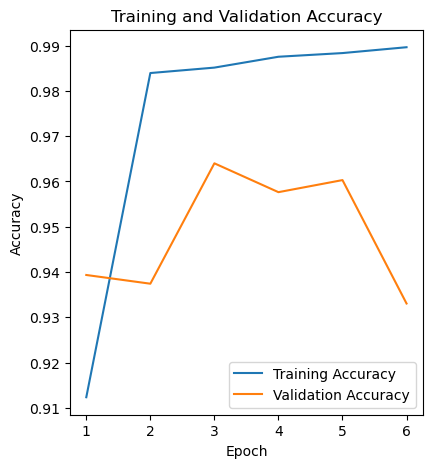

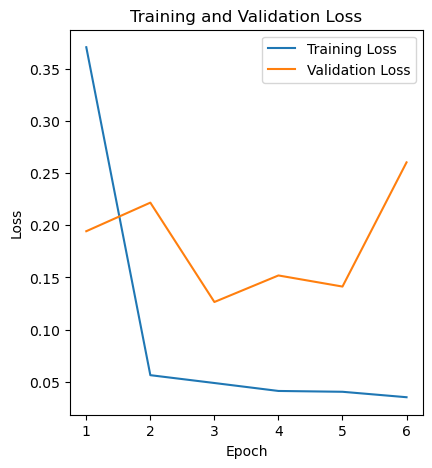

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.savefig('../images/inceptionv3-4-1-Accuracy.png')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training and Validation Loss')

plt.savefig('../images/inceptionv3-4-2-Loss.png')